In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop

WINDOW_SIZE = 5
SEQUENCE_LENGTH = 1
N_FEATURES = 6
N_EPOCHS = 100

# Load data
raw = pd.read_csv('sales_train.csv')
raw['date'] = pd.to_datetime(raw['date'], format='%d.%m.%Y')
raw = raw.sort_values(by=['date']).groupby(['date']).sum()['item_cnt_day'].to_frame()



Using TensorFlow backend.


Feature Engineering

In [2]:
#add month day week of day
raw['month']=raw.index.month
raw['day']=raw.index.day
raw['year']=raw.index.year
raw['dow']=raw.index.dayofweek
raw = pd.get_dummies(raw, columns=['dow'])
raw['date']=raw.index

In [3]:
data = pd.read_csv('sales_train.csv')
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [4]:
# generate the item_cnt and price related feature
gb = data.groupby(['date'], as_index=True).agg(
    {'item_cnt_day':{'item_target':'sum', 
                     'item_target_std': np.std,
                     'item_count_days': 'count'},
     'item_price':{'item_price_med':np.median, 
                   'item_price_mean': np.mean,
                   'item_price_std': np.std},
    })
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
gb['date']=gb.index

In [5]:
#merge two data frame
all_data = pd.merge(raw,gb)
all_data.index = all_data['date']
all_data= all_data.drop(['item_target','date'],axis=1)

In [6]:
#split tran data and test data
y_train=all_data['2013-01':'2015-09']['item_cnt_day']
y_test=all_data['2015-09':'2015-10']['item_cnt_day']
all_data_without=all_data.drop(['item_cnt_day'],axis=1)
x_train=all_data_without['2013-01':'2015-09']
x_test=all_data_without['2015-09':'2015-10']
train = all_data['2013-01':'2015-09']
test =all_data['2015-10']

scale data

In [7]:
x_scaler = MinMaxScaler().fit(all_data['item_cnt_day'].reshape(-1, 1))
train_y = x_scaler.transform(y_train.reshape(-1, 1)).reshape(-1,)
test_y = x_scaler.transform(y_test.reshape(-1, 1)).reshape(-1,)



In [8]:
col=['item_target_std', 'item_count_days',
       'item_price_med', 'item_price_mean', 'item_price_std']
train_x=x_train
test_x=x_test
for c in col:
    train_x[c] = x_scaler.transform(x_train[c].reshape(1, -1)).reshape(-1,)
    test_x[c] = x_scaler.transform(x_test[c].reshape(1, -1)).reshape(-1,)

In [9]:
train_x=np.array(train_x).reshape(1003,15,1)

In [10]:
#train model
model = Sequential()
model.add(LSTM(8, input_shape=train_x[0].shape))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Train
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_x, train_y, batch_size=16, epochs=N_EPOCHS, verbose=0)

In [11]:
y_pred = model.predict(np.array(test_x).reshape(-1,15,1))
test_pred = x_scaler.inverse_transform(y_pred.reshape(1, -1)).reshape(-1,)
test_true = x_scaler.inverse_transform(test_y.reshape(1, -1)).reshape(-1,)

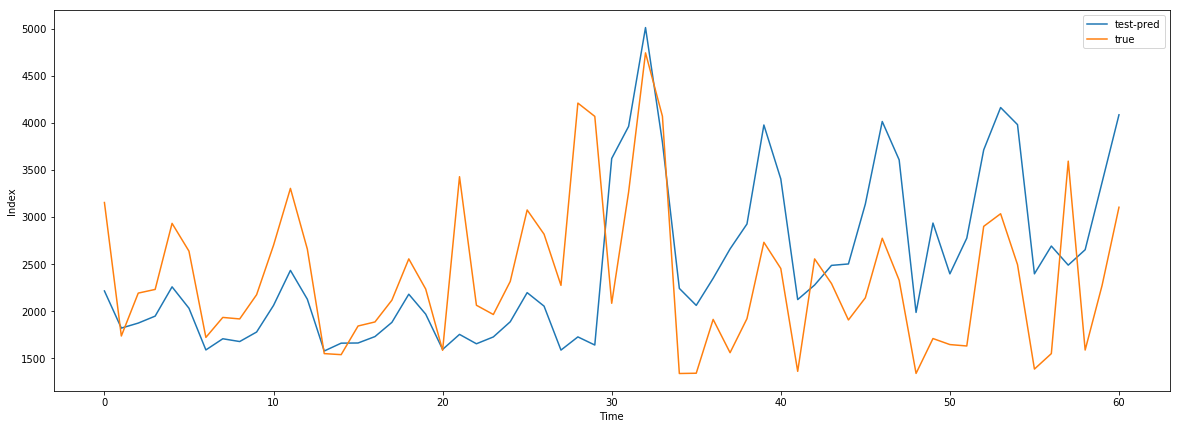

In [12]:
#test result
plt.figure(figsize=(20, 7))
plt.xlabel('Time')
plt.ylabel('Index')
plt.plot(test_pred, label='test-pred')
plt.plot(test_true, label='true')
plt.legend()
plt.show()

In [13]:
test_MSE=np.mean((test_true- test_pred)**2)
MSE = ((test_true-test_pred)**2).sum()/test_true.size
RMSE = np.sqrt(((test_true-test_pred)**2).sum()/test_true.size)
MAE= (np.abs(test_true-test_pred)).sum()/test_true.size
MAPE=(np.abs(test_true-test_pred)*100/test_true).sum()/test_true.size
print(MAE)


743.3836990106302


In [14]:
train_pred = model.predict(np.array(train_x).reshape(-1,15,1))
train_pred=x_scaler.inverse_transform(train_pred.reshape(1, -1)).reshape(-1,)
train_true =x_scaler.inverse_transform(train_y.reshape(1, -1)).reshape(-1,)

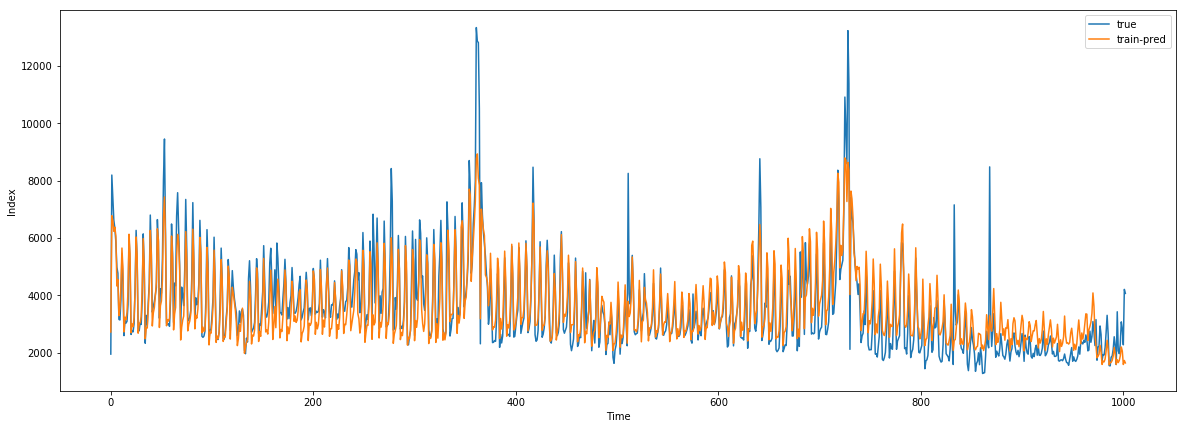

In [15]:
#training result
plt.figure(figsize=(20, 7))
plt.xlabel('Time')
plt.ylabel('Index')
plt.plot(train_true, label='true')
plt.plot(train_pred, label='train-pred')
plt.legend()
plt.show()

In [16]:
train_MSE=np.mean((train_true- train_pred)**2)


In [17]:
#compute loss
MSE = ((train_true-train_pred)**2).sum()/train_true.size
RMSE = np.sqrt(((train_true-train_pred)**2).sum()/train_true.size)
MAE= (np.abs(train_true-train_pred)).sum()/train_true.size
MAPE=(np.abs(train_true-train_pred)*100/train_true).sum()/train_true.size
print(MAE)


516.7760564741322


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


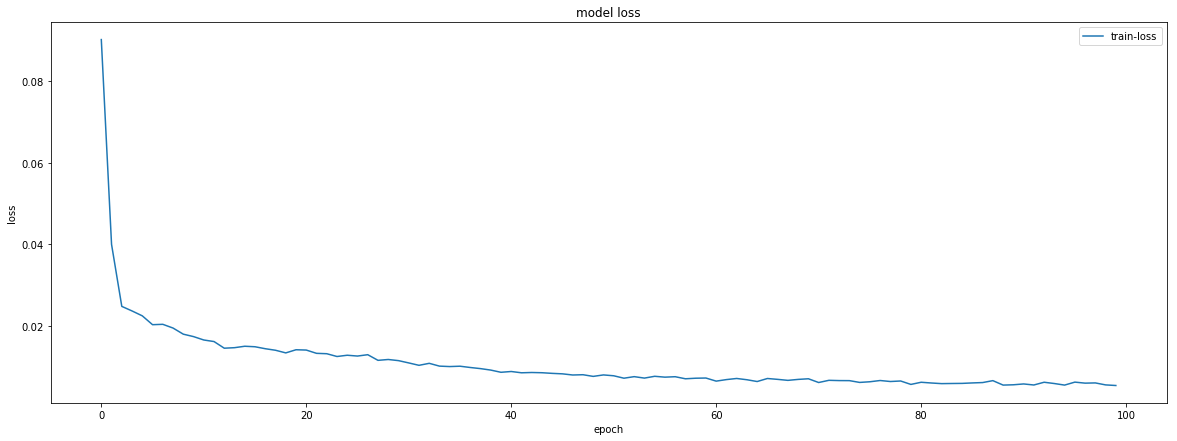

In [19]:
#plot train loss
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss'], loc='upper right')
plt.show()